In [6]:
import torch
import triton
import triton.language as tl

DEVICE = triton.runtime.driver.active.get_active_torch_device()
DEVICE

device(type='cuda', index=0)

In [53]:
@triton.jit
def layernorm_fwd_kernel(
    x_ptr,  # shape (M, N)
    y_ptr,  # shape (M, N)
    w_ptr,  # shape (N)
    b_ptr,  # shape (N)
    mean_ptr,  # shape (M)
    inv_var_ptr,  # shape (M)
    N,  # shape (N)
    BLOCK_SIZE: tl.constexpr,
    EPS: tl.constexpr,
):
    """
    x = (x-E[x]) / sqrt(Var[x]+eps) * w + b
    """
    pid_m = tl.program_id(axis=0)
    x_ptr += pid_m * N
    y_ptr += pid_m * N

    offsets = tl.arange(0, BLOCK_SIZE)
    block_x = tl.zeros((BLOCK_SIZE,), dtype=tl.float32)
    for off in range(0, N, BLOCK_SIZE):
        cols = off + offsets
        x = tl.load(x_ptr + cols, mask=cols < N, other=0.0).to(tl.float32)
        block_x += x
    mean = tl.sum(block_x, axis=0) / N

    block_x = tl.zeros((BLOCK_SIZE,), dtype=tl.float32)
    for off in range(0, N, BLOCK_SIZE):
        cols = off + offsets
        x = tl.load(x_ptr + cols, mask=cols < N, other=0.0).to(tl.float32)
        x = tl.where(cols < N, x - mean, 0.0)
        block_x += x * x
    var = tl.sum(block_x, axis=0) / N
    inv_var = 1.0 / tl.sqrt(var + EPS)

    tl.store(mean_ptr + pid_m, mean)
    tl.store(inv_var_ptr + pid_m, inv_var)

    for off in range(0, N, BLOCK_SIZE):
        cols = off + offsets
        x = tl.load(x_ptr + cols, mask=cols < N, other=0.0).to(tl.float32)
        w = tl.load(w_ptr + cols, mask=cols < N, other=0.0)
        b = tl.load(b_ptr + cols, mask=cols < N, other=0.0)
        x = tl.where(cols < N, (x - mean) * inv_var * w + b, 0.0)
        tl.store(y_ptr + cols, x, mask=cols < N)


@triton.jit
def layernorm_bwd_stage1_kernel(
    dy_ptr,  # [m,n]
    dx_ptr,  # [m,n]
    dw_ptr,  # [m/GROUP_SIZE, n]
    db_ptr,  # [m/GROUP_SIZE, n]
    x_ptr,  # [m,n]
    w_ptr,  # [n]
    mean_ptr,  # [m]
    rstd_ptr,  # [m]
    lock_ptr,
    STRIDE,
    N,
    GROUP_SIZE: tl.constexpr,
    BLOCK_SIZE: tl.constexpr,
):
    """
    Compute: dx = Rstd * ( dy*w - 1/N(x_hat @ (dy*w)) * x_hat - 1/N* dy@w )
    where x_hat = (x-mean)*Rstd
    Also compute partial dw and db.
    """
    row = tl.program_id(axis=0)

    dy_ptr += STRIDE * row
    dx_ptr += STRIDE * row
    x_ptr += STRIDE * row

    group_id = row % GROUP_SIZE
    dw_ptr += N * group_id
    db_ptr += N * group_id
    lock_ptr += group_id
    cnt_ptr = lock_ptr + GROUP_SIZE

    mean = tl.load(mean_ptr + row)
    rstd = tl.load(rstd_ptr + row)

    cols = tl.arange(0, BLOCK_SIZE)
    mask = cols < N

    # compute dx
    x = tl.load(x_ptr + cols, mask=mask).to(tl.float32)
    dy = tl.load(dy_ptr + cols, mask=mask).to(tl.float32)
    w = tl.load(w_ptr + cols, mask=mask).to(tl.float32)
    x_hat = tl.where(mask, (x - mean) * rstd, 0.0)
    dyw = tl.where(mask, dy * w, 0.0)
    c2 = tl.sum(dyw, axis=0) / N
    c1 = tl.sum(x_hat * dyw, axis=0) / N
    dx = (dyw - (x_hat * c1 + c2)) * rstd
    tl.store(dx_ptr + cols, dx, mask=mask)

    # compute d_w, d_b
    partial_dw = (dy * x_hat).to(w.dtype)
    partial_db = dy.to(w.dtype)

    # get write lock
    while tl.atomic_cas(lock_ptr, 0, 1) == 1:
        pass
    if tl.load(cnt_ptr) == 0:
        tl.atomic_xchg(cnt_ptr, 1)
    else:
        partial_dw += tl.load(dw_ptr + cols, mask=mask)
        partial_db += tl.load(db_ptr + cols, mask=mask)
    tl.store(dw_ptr + cols, partial_dw, mask=mask)
    tl.store(db_ptr + cols, partial_db, mask=mask)

    tl.debug_barrier()  # ensure all threads finished
    tl.atomic_xchg(lock_ptr, 0)


@triton.jit
def layernorm_bwd_stage2_kernel(
    partial_dw_ptr, partial_db_ptr, dw_ptr, db_ptr, M, N, BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr  # [M, N]  # [M, N]  # [N]  # [N]
):
    """
    Parallel sum reduction in Rows.
    """
    pid_n = tl.program_id(axis=0)
    cols = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    cols_mask = cols < N
    dw = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
    db = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
    for i in range(0, M, BLOCK_SIZE_M):
        rows = i + tl.arange(0, BLOCK_SIZE_M)
        rows_mask = rows < M
        mask = rows_mask[:, None] & cols_mask[None, :]
        offs = (rows * N)[:, None] + cols[None, :]
        dw += tl.load(partial_dw_ptr + offs, mask=mask, other=0.0)
        db += tl.load(partial_db_ptr + offs, mask=mask, other=0.0)
    sum_dw = tl.sum(dw, axis=0)
    sum_db = tl.sum(db, axis=0)
    tl.store(dw_ptr + cols, sum_dw, mask=cols_mask)
    tl.store(db_ptr + cols, sum_db, mask=cols_mask)


class LayerNorm(torch.autograd.Function):
    @staticmethod
    def forward(
        ctx,
        x: torch.Tensor,
        w: torch.Tensor,
        b: torch.Tensor,
        eps: float,
    ):
        assert x.ndim == 2 and w.ndim == 1 and b.ndim == 1
        assert x.shape[1] == w.shape[0] and x.shape[1] == b.shape[0]
        assert x.is_contiguous()
        assert w.is_contiguous()
        assert b.is_contiguous()

        y = torch.empty_like(x)
        x = x.view(-1, x.size(-1))
        M, N = x.shape
        mean = torch.empty((N,), dtype=torch.float32, device=x.device)
        rstd = torch.empty((N,), dtype=torch.float32, device=x.device)

        # compute launch config
        MAX_FUSED_SIZE = 65536 // x.element_size()
        BLOCK_SIZE_N = min(MAX_FUSED_SIZE, triton.next_power_of_2(N))
        assert N <= BLOCK_SIZE_N, "This layer norm is not supported for fim >= 64KB"
        num_warps = min(8, max(BLOCK_SIZE_N // 256, 1))

        # launch kernel
        layernorm_fwd_kernel[(M,)](  #
            x, y, w, b, mean, rstd, N, BLOCK_SIZE_N, eps, num_warps=num_warps, num_ctas=1
        )  # type:ignore
        ctx.save_for_backward(x, w, b, mean, rstd)
        ctx.BLOCK_SIZE_N = BLOCK_SIZE_N
        ctx.EPS = eps
        ctx.mum_warps = num_warps
        return y

    @staticmethod
    def backward(ctx, dy: torch.Tensor):
        x, w, b, mean, rstd = ctx.saved_tensors
        N = w.shape[0]
        GROUP_SIZE_M = 256
        if N <= 8192:
            GROUP_SIZE_M = 128
        if N <= 4096:
            GROUP_SIZE_M = 96
        if N <= 1024:
            GROUP_SIZE_M = 96

        locks = torch.zeros((GROUP_SIZE_M * 2,), dtype=torch.int32, device=w.device)
        partial_dw = torch.zeros((GROUP_SIZE_M, N), dtype=w.dtype, device=w.device)
        partial_db = torch.zeros((GROUP_SIZE_M, N), dtype=w.dtype, device=w.device)
        dw = torch.empty((N,), dtype=w.dtype, device=w.device)
        db = torch.empty((N,), dtype=w.dtype, device=w.device)
        dx = torch.empty_like(x)

        x = x.view(-1, x.size(-1))
        M, N = x.shape
        layernorm_bwd_stage1_kernel[(M,)](
            dy, dx, partial_dw, partial_db, x, w, mean, rstd, locks, x.stride(0), N, GROUP_SIZE_M, ctx.BLOCK_SIZE_N, num_warps=ctx.mum_warps
        )

        grid = lambda meta: (triton.cdiv(N, meta["BLOCK_SIZE_N"]),)
        layernorm_bwd_stage2_kernel[grid](
            partial_dw, partial_db, dw, db, min(GROUP_SIZE_M, M), N, BLOCK_SIZE_M=32, BLOCK_SIZE_N=128  #  #
        )
        return dx, dw, db, None


layer_norm = LayerNorm.apply

In [48]:
def test_layer_norm(M, N, dtype, eps=1e-5, device=DEVICE):
    # create data
    x_shape = (M, N)
    w_shape = (x_shape[-1], )
    weight = torch.rand(w_shape, dtype=dtype, device=device, requires_grad=True)
    bias = torch.rand(w_shape, dtype=dtype, device=device, requires_grad=True)
    x = -2.3 + 0.5 * torch.randn(x_shape, dtype=dtype, device=device)
    dy = .1 * torch.randn_like(x)
    x.requires_grad_(True)
    
    # forward pass
    y_tri = layer_norm(x, weight, bias, eps)
    y_ref = torch.nn.functional.layer_norm(x, w_shape, weight, bias, eps).to(dtype)
    assert torch.allclose(y_tri, y_ref, atol=1e-2, rtol=0)
    print("Forward pass OK!")
    
    # backward pass (triton)
    y_tri.backward(dy, retain_graph=True)
    dx_tri, dw_tri, db_tri = [_.grad.clone() for _ in [x, weight, bias]]
    x.grad, weight.grad, bias.grad = None, None, None
    # backward pass (torch)
    y_ref.backward(dy, retain_graph=True)
    dx_ref, dw_ref, db_ref = [_.grad.clone() for _ in [x, weight, bias]]
    # compare
    assert torch.allclose(dx_tri, dx_ref, atol=1e-2, rtol=0)
    assert torch.allclose(db_tri, db_ref, atol=1e-2, rtol=0)
    assert torch.allclose(dw_tri, dw_ref, atol=1e-2, rtol=0)
    print("Backward pass OK!")
    
test_layer_norm(1151, 8192, torch.float16)


Forward pass OK!
Backward pass OK!


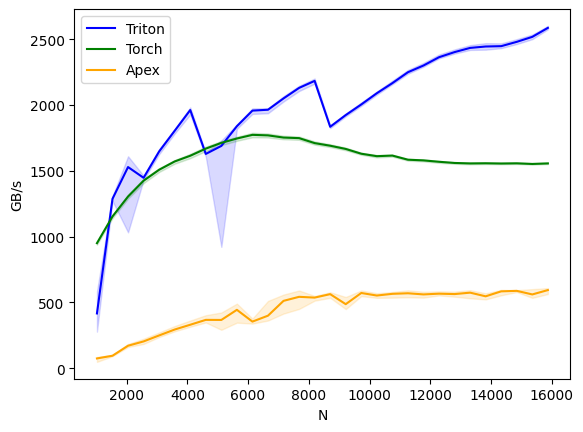

layer-norm-backward:
          N       Triton        Torch        Apex
0    1024.0   415.771591   949.797080   73.755082
1    1536.0  1287.122758  1153.126078   94.285098
2    2048.0  1528.536477  1304.198988  170.333987
3    2560.0  1446.710861  1424.695621  203.086465
4    3072.0  1646.978018  1508.019138  248.654490
5    3584.0  1804.334416  1571.068431  293.460424
6    4096.0  1961.788604  1614.435725  329.844606
7    4608.0  1628.223632  1668.526100  366.891535
8    5120.0  1689.072227  1712.240348  366.327557
9    5632.0  1839.020468  1745.510889  443.219170
10   6144.0  1957.515852  1773.240131  353.770591
11   6656.0  1964.191291  1769.403949  398.744749
12   7168.0  2050.288257  1752.634099  511.357937
13   7680.0  2130.097543  1748.403816  542.030468
14   8192.0  2183.396194  1710.564406  536.218841
15   8704.0  1834.684155  1690.609984  562.469803
16   9216.0  1923.600448  1666.169544  486.277313
17   9728.0  2004.320271  1629.821997  571.250829
18  10240.0  2089.629324  161

In [58]:
try:
    # This is https://github.com/NVIDIA/apex, NOT the apex on PyPi, so it
    # should not be added to extras_require in setup.py.
    import apex
    HAS_APEX = True
except ModuleNotFoundError:
    HAS_APEX = False

@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],
        x_vals=[512 * i for i in range(2, 32)],
        line_arg='provider',
        line_vals=['triton', 'torch'] + (['apex'] if HAS_APEX else []),
        line_names=['Triton', 'Torch'] + (['Apex'] if HAS_APEX else []),
        styles=[('blue', '-'), ('green', '-'), ('orange', '-')],
        ylabel='GB/s',
        plot_name='layer-norm-backward',
        args={'M': 4096, 'dtype': torch.float16},
    ))
def bench_layer_norm(M, N, dtype, provider, mode='backward', eps=1e-5, device=DEVICE):
    # create data
    x_shape = (M, N)
    w_shape = (x_shape[-1], )
    weight = torch.rand(w_shape, dtype=dtype, device=device, requires_grad=True)
    bias = torch.rand(w_shape, dtype=dtype, device=device, requires_grad=True)
    x = -2.3 + 0.5 * torch.randn(x_shape, dtype=dtype, device=device)
    dy = .1 * torch.randn_like(x)
    x.requires_grad_(True)
    quantiles = [0.5, 0.2, 0.8]

    def y_fwd():
        if provider == "triton":
            return layer_norm(x, weight, bias, eps)  # noqa: F811, E704

        if provider == "torch":
            return torch.nn.functional.layer_norm(x, w_shape, weight, bias, eps)  # noqa: F811, E704

        if provider == "apex":
            apex_layer_norm = (apex.normalization.FusedLayerNorm(w_shape).to(x.device).to(x.dtype))
            return apex_layer_norm(x)  # noqa: F811, E704

    # forward pass
    if mode == 'forward':
        gbps = lambda ms: 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
        ms, min_ms, max_ms = triton.testing.do_bench(y_fwd, quantiles=quantiles, rep=500)
    # backward pass
    if mode == 'backward':
        y = y_fwd()
        gbps = lambda ms: 3 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)  # noqa: F811, E704
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True), quantiles=quantiles,
                                                     grad_to_none=[x], rep=500)
    return gbps(ms), gbps(max_ms), gbps(min_ms)


bench_layer_norm.run(show_plots=True, print_data=True, mode='forward')

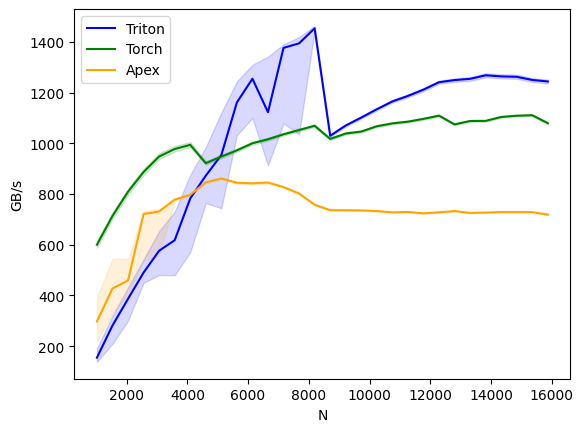

layer-norm-backward:
          N       Triton        Torch        Apex
0    1024.0   154.992511   600.329788  297.834492
1    1536.0   281.807917   713.640647  427.563602
2    2048.0   386.833230   809.086412  459.230365
3    2560.0   490.416560   886.820073  721.232566
4    3072.0   576.422156   947.889077  731.111273
5    3584.0   617.847789   977.454538  777.985317
6    4096.0   782.519427   993.910936  796.992142
7    4608.0   872.305661   921.600023  846.030131
8    5120.0   953.713270   947.508449  861.182684
9    5632.0  1161.018935   972.103831  844.635014
10   6144.0  1254.611008  1000.125462  842.154552
11   6656.0  1122.487430  1015.860069  845.346097
12   7168.0  1376.255935  1035.362758  827.325530
13   7680.0  1394.053464  1052.317560  802.045133
14   8192.0  1453.327744  1069.066463  757.824107
15   8704.0  1029.678362  1017.144215  736.278446
16   9216.0  1070.299135  1038.574913  735.976717
17   9728.0  1101.607793  1046.226561  735.344877
18  10240.0  1134.331468  106

In [59]:
bench_layer_norm.run(show_plots=True, print_data=True, mode='backward')